# Kalman Filter Walkthrough

This notebook will walk through the Kalman Filter (KF) algorithm. It is a simple state-space model which makes some Gaussian assumptions about the transition dynamics and the emission dynamics. This results in a very simple model to use because all of the important quantities of interest (e.g. filtering, smoothing, and forecasting) are available in closed-form.

**Resources**:

* 

## Model

**Transition Model**

This model describes the transition dynamics between the different states at time $t$ and $t+1$.

$$
\mathbf{z}_{t} = \mathbf{A}_t \mathbf{z}_{t-1} + \mathbf{Q}_t
$$

Notice how it assumes a linear transition with an additive Gaussin noise assumption, $\boldsymbol{\epsilon}_{\mathbf{z}_t} \sim \mathcal{N}(\mathbf{0},\mathbf{Q}_t)$. We can also rewrite this as a conditional distribution.

$$
p(\mathbf{z}_{t}|\mathbf{z}_{t-1}) = \mathcal{N}(\mathbf{z}_t|\mathbf{A}_t\mathbf{z}_{t-1}, \mathbf{Q}_t)
$$

---
**Observation Model**

$$
\mathbf{x}_t = \mathbf{C}_t\mathbf{z}_t + \mathbf{R}_t
$$

where can also rewrite this as a distribution:

$$
p(\mathbf{x}_t|\mathbf{z}_t) = \mathcal{N}(\mathbf{x}_t|\mathbf{C}_t\mathbf{z}_t, \mathbf{R}_t)
$$


---
**Free Parameters**

In this case, we have the following free parameters, $\boldsymbol{\theta}_t$, in this model:

$$
\boldsymbol{\theta}_t = \left\{\mathbf{A}_t, \mathbf{Q}_t, \mathbf{C}_t, \mathbf{R}_t \right\}
$$

**Note**: we can assume the parameters are independent of time, $t$, which would provide us with a simpler model. This is called a *stationary* assumption which may be cheaper, but also invalid in some cases.

In [48]:
import numpy as np
from typing import NamedTuple
from dataclasses import dataclass
from scipy import stats
from einops import repeat
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter, update, predict, batch_filter, rts_smoother



## Example I - Noisy 1D Signal


$$
\begin{aligned}
y_t &= x_t + \epsilon_y
\end{aligned}
$$

where $\epsilon_y \sim \mathcal{N}(0, \sigma^2)$ and $t = [0, 100]$. 

So essentially, this is a trivial example where we have a straight line

In [29]:
from tqdm.notebook import trange

time_steps = 100
scale = 10

true_observations = []
noisy_observations = []

for t in trange(time_steps):
    
    # true signal
    true_observations.append(t)
    
    # noisy signal    
    z = t + scale * np.random.randn()
    
    noisy_observations.append(z)
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

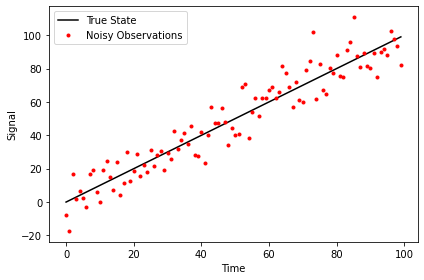

In [30]:
# plot the signal
fig, ax = plt.subplots()
ax.plot(true_observations, marker="", linestyle="-", label="True State", color="k")
ax.plot(noisy_observations, marker=".", linestyle="", label="Noisy Observations", color="red")
ax.set(xlabel="Time", ylabel="Signal")
plt.legend()
plt.tight_layout()

---
Like before, we can describe the dynamical system like so:

$$
\begin{aligned}
\mathbf{z}_{t+1} &= \mathbf{F}\mathbf{z}_t + \boldsymbol{\epsilon}_\mathbf{z} \\
x_t &= \mathbf{H}\mathbf{z}_t + \boldsymbol{\epsilon}_x
\end{aligned}
$$

We can manually define the terms, $\mathbf{F}$ and $\mathbf{H}$, which represent the relationship between the variables. Here they will be

$$
\begin{aligned}
\mathbf{F} &=
\begin{bmatrix}
1 & 1 \\ 0 & 1
\end{bmatrix} \\
\mathbf{H} &=
\begin{bmatrix}
1 & 0 
\end{bmatrix}
\end{aligned}
$$

Here, we assume that the state system is as follows:

$$
\begin{aligned}
\frac{\partial z^1}{\partial t} &= z^1 + z^2 \\
\frac{\partial z^2}{\partial t} &= z^1
\end{aligned}
$$

and we assume that the observation is related like so:

$$
x = z^1
$$

So essentially, we have an augmented the state space dimension, $\mathbf{z} \in \mathbb{R}^2$, which is higher than the observation space, $x \in \mathbb{R}^1$. Our assumption here is that there are higher order dynamics at play behind the scenes. 


#### Setup

In [45]:
# initialize Kalman Filter
dim_z = 2
dim_x = 1


# init transition model
F = np.array([[1., 1.], [0., 1.]])   # state transition matrix
Q = 1e-4 * np.eye((2))              # state uncertainty

assert F.shape == (dim_z, dim_z)
assert Q.shape == (dim_z, dim_z)

# init emission model
H = np.array([[1., 0.]]).T             # emission matrix
R = 5 * np.eye((1))                  # emission uncertainty

assert H.shape == (dim_z, dim_x)
assert R.shape == (dim_x, dim_x)

# init state
init_mean = np.array([2., 0.])
init_cov = np.eye(init_mean.shape[0])

assert init_mean.shape == (dim_z,)
assert init_cov.shape == (dim_z, dim_z)
init_state = KFState(mean=init_mean, cov=init_cov)

mean, cov = init_mean, init_cov


### Filtering

In [46]:



observations = []
states = []
means, covs = [], []
time_steps = 100
# run the kalman filter
with trange(time_steps) as pbar:
    for t in pbar:
        
        # noisy signal
        pbar.set_description("Running: Generating signal")
        obs = t + scale * np.random.randn(1,1)

        observations.append(obs.squeeze())

        # run update eqns
        pbar.set_description("Runing: Update Equation")
        mean, cov = update(x=mean, P=cov, z=obs, R=R, H=H.T)
        
        # run predict eqns
        pbar.set_description("Runing: Predict Equation")
        mean, cov  = predict(x=mean, P=cov, F=F, Q=Q)
        # break
        
        # keep the estimated state
        states.append(mean[0])
        
        means.append(mean)
        covs.append(cov)


  0%|          | 0/100 [00:00<?, ?it/s]

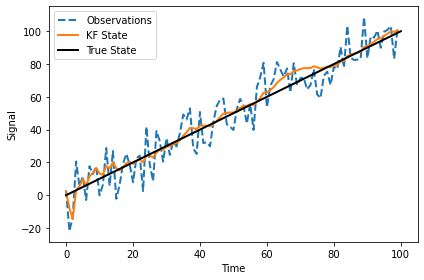

In [47]:
# plot the signal
fig, ax = plt.subplots()
ax.plot(observations, label="Observations", linewidth=2, linestyle="--")
ax.plot(states, label="KF State", linewidth=2, )
ax.plot([0,100], [0,100], label="True State", linewidth=2, color="black" )
ax.set(xlabel="Time", ylabel="Signal")
plt.legend()
plt.tight_layout()
plt.show()

As we can see, it does a fairly good job at getting the state.

### Smoothing

In [54]:
n_states = len(means)
Xs = np.array(means)
Ps = np.array(covs)
Fs = [F] * n_states
Qs = [Q] * n_states
mean_sm, covs_sm, Ks, pred_covs = rts_smoother(Xs=Xs, Ps=Ps, Fs=Fs, Qs=Qs)

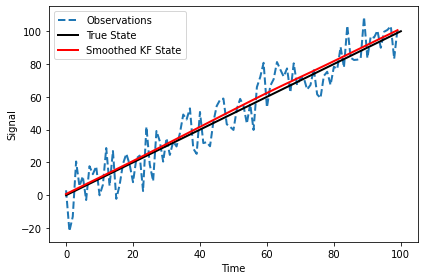

In [70]:
# plot the signal
fig, ax = plt.subplots()
ax.plot(observations, label="Observations", linewidth=2, linestyle="--")
ax.plot([0,100], [0,100], label="True State", linewidth=2, color="black" )
ax.plot(mean_sm[:, 0], label="Smoothed KF State", linewidth=2, color="red")
ax.set(xlabel="Time", ylabel="Signal")
plt.legend()
plt.tight_layout()
plt.show()

## Example II - Object Tracking

In this example, we consider an object moving in a 2D plane. 

---

#### State Transition Dynamics

We assume that we can fully describe the state when we have the `(x,y)` coordinates of the position and the `(x,y)` velocity. So we can write this as:

$$
\mathbf{z}_t = 
\begin{bmatrix}
z_t^1 \\ z_t^2 \\ \dot{z}_t^1 \\ \dot{z}_t^2
\end{bmatrix}
$$

where $z_t^d$ is the coordinate of the position and $\dot{z}^d$ is the velocity. 

We can describe the dynamics of the system using the following system of equations:

$$
\begin{aligned}
z_t^1 &= z_{t-1}^1 + \Delta_t \dot{z}_t^1 + \epsilon_t^1 \\
z_t^2 &= z_{t-1}^2 + \Delta_t \dot{z}_t^2 + \epsilon_t^2 \\
\dot{z}_t^1 &= \dot{z}_{t-1}^1 + \epsilon_t^3 \\
\dot{z}_t^2 &= \dot{z}_{t-1}^2 + \epsilon_t^4 \\
\end{aligned}
$$

This is a very simple formulation which takes a first order approximation to the change in position based on speed and we also assume constant velocity. Note, we also include some noise because we assume that some of the dynamics are noisy, i.e. there are random acceleration and position changes in the model. 


We can also put this into matrix formulation like so:

$$
\mathbf{z}_t = \mathbf{A}_t \mathbf{z}_{t-1} + \boldsymbol{\epsilon}_t
$$

where:

$$
\mathbf{A}_t = 
\begin{bmatrix}
1 & 0 & \Delta_t & 0 \\
0 & 1 & 0 & \Delta_t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}, \;\; \mathbf{A}_t \in \mathbb{R}^{4\times 4}
$$

In [37]:
state_ndims = 4
Δ = 1.0

A = np.array([
    [1, 0, Δ, 0], 
    [0, 1, 0, Δ], 
    [0, 0, 1, 0], 
    [0, 0, 0, 1]
])
R = np.eye(state_ndims)

assert A.shape == (state_ndims, state_ndims)

---
#### Emissions Model

We can only fully observe the locations (not the velocities). So this will be a lower dimensional vector of size 2-D. The system of equations are as follows:

$$
\begin{aligned}
x_t^1 &= z_t^1 + \delta_t^1 \\
x_t^2 &= z_t^2 + \delta_t^2 \\
\end{aligned}
$$

This is a very simple model where we assume we can extract the direct positions (plus some noise) from the state.

We can write this in an abbreviated matrix formulation:

$$
\mathbf{x}_t = \mathbf{C}_t \mathbf{z}_t + \delta_t
$$

where:

$$
\mathbf{C}_t = 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{bmatrix}, \;\; \mathbf{C}_t \in \mathbb{R}^{2 \times 4}
$$


In [38]:
obs_ndims = 2

C = np.array([
    [1, 0, 0, 0], 
    [0, 1, 0, 0]
])
Q = 0.01 * np.eye(obs_ndims)

assert C.shape == (obs_ndims, state_ndims)
assert Q.shape == (obs_ndims, obs_ndims)

---

**Prior**

Typically we specify a wide prior (maximum entropy) if we have no strong assumptions. Many times this is often the least important aspect as this tends to get "washed away" as we acquire more observations. However, this can be very important in cases where we don't have many observations and can greatly speed up training and convergence.

As with most things, we typically assume a Gaussian:

$$
p(\mathbf{z}_0) = \mathcal{N}(\mathbf{z}_0| \boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0)
$$

## Marginal Likelihood

We can compute the log-likelihood of the sequence, i.e. the likelihood that the parameters given fit the data seen/trained-on. This allows us to actually train the Kalman Filter given the data. The equation is given by:

$$
p(\mathbf{x}_t) = \sum_t \log p(\mathbf{x}_t|\mathbf{x}_{1:t-1})
$$

We can write this probability distribution exactly because we know it is Gaussian distributed

$$
p(\mathbf{x}_t|\mathbf{x}_{1:t-1})= \mathcal{N}(\mathbf{C}_t \boldsymbol{\mu}_{t|t-1}, \mathbf{S}_t)
$$

where:
*  ${\boldsymbol \mu}_{t:t-1}$ - is the mean
* 


## Posterior Predictive

This is a one-step-ahead predictive density for the observations. It predicts the next time step using all of the previous observations. It is given by these equations:

$$
p(\mathbf{x}_t|\mathbf{x}_{1:t-1}) = \int \mathcal{N}(\mathbf{x}_t|\mathbf{Cz}_t, \mathbf{R})\mathcal{N}(\mathbf{z}_t|\boldsymbol{\mu}_{t|t-1},\boldsymbol{\Sigma}_{t|t-1})d\mathbf{z}_t
$$

In [21]:
def forecast():
    return None

## Smoothing Algorithm

This is a message passing algorithm that propagates from right to left after everything has been observed.

$$
\begin{aligned}
p(\mathbf{z}_t|\mathbf{x}_{1:T}) &= \mathcal{N}(\mathbf{z}_t|\boldsymbol{\mu}_{t:T},\boldsymbol{\Sigma}_{t:T})
\end{aligned}
$$

This is given by these equations:

$$
\begin{aligned}
\boldsymbol{\mu}_{t|T} &= \boldsymbol{\mu}_{t|t} + \mathbf{J}_t \left(\boldsymbol{\mu}_{t+1|T} - \boldsymbol{\mu}_{t+1|t} \right) \\
\boldsymbol{\Sigma}_{t|T} &= \boldsymbol{\Sigma}_{t|t} + \mathbf{J}_t \left(\boldsymbol{\mu}_{t+1|T} - \boldsymbol{\mu}_{t+1|t} \right) \mathbf{J}_t^\top \\
\mathbf{J}_t &= \boldsymbol{\Sigma}_{t|t} \mathbf{A}_{t+1}^\top \boldsymbol{\Sigma}_{t+1|t}^{-1}
\end{aligned}
$$


In [22]:
def smoother_step(state, dist):
    
    mean = state.mean
    cov = state.cov
    
    J = cov @ A.T @ np.linalg.inv(cov)
    return None

## Application III - Predator-Prey Model